In [1]:
!pip install pmdarima==2.0.4 -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 40.8 MB/s eta 0:00:00


# Context

This project focuses on forecasting **daily energy consumption** using time series modeling techniques, with a specific emphasis on the **AEP region** from the PJM Interconnection dataset. PJM Interconnection LLC is a regional transmission organisation (RTO) in the United States, coordinating the movement of wholesale electricity across multiple states in the Eastern Interconnection grid. The dataset provides historical hourly energy consumption (in megawatts), which I aggregate to a **daily level** to align with my goal of estimating broader consumption trends rather than granular hourly variations.

The central aim of this work is to **anticipate future energy usage patterns** to support energy planning, load balancing, and infrastructure optimisation.

Rather than relying solely on traditional time series methods, this project explores the **complementary strengths of Prophet and ARIMA**, as well as **ensemble strategies like model stacking**. By comparing performance and diagnostics across these approaches, I aim to deliver a **robust, interpretable, and scalable** daily forecasting model.

---

### **Objectives**

- **Aggregate and prepare time series data**  
  Clean and transform hourly energy consumption data into a reliable daily format, accounting for missing values, seasonality, and structural changes in the data.

- **Build and compare forecasting models**  
  Use **Prophet** and **ARIMA** as primary modeling techniques, with extensions into **stacked ensembles** to improve predictive performance and resilience to non-linear trends.

- **Evaluate and visualise forecasts**  
  Assess model accuracy using time-based cross-validation, while also exploring visual diagnostics to interpret trends, seasonality, and anomaly patterns.

---

> You can find the dataset [here](https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption?select=AEP_hourly.csv).  
> View full analysis on [GitHub]()

**NOTE**: This project is part of my weekly series in efforts to **demystify applied statistical techniques through real-world, project-driven examples**, making concepts like propensity modelling, causal inference, and evaluation metrics more accessible to practitioners of all backgrounds.

---

### Let’s connect! → [LinkedIn](https://www.linkedin.com/in/einstein-ebereonwu/) | [X](https://x.com/einsteinmuna) | [GitHub](https://github.com/munas-git)

# Importing Important Libraries

In [2]:
# data wrangling
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

# numerical analysis
import numpy as np
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller

# data vis
import seaborn as sns
import matplotlib.pyplot as plt

# model training
from prophet import Prophet
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.tree import DecisionTreeRegressor

# model evaluation
from sklearn.metrics import silhouette_score, mean_squared_error

# hyper-params optimisation
from sklearn.model_selection import RandomizedSearchCV

# handling warnings
import warnings
warnings.filterwarnings('ignore')

print('All done...')

All done...


In [3]:
aep_df = pd.read_csv('/kaggle/input/hourly-energy-consumption/AEP_hourly.csv')
aep_df.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


In [4]:
aep_df.describe().T

,count,mean,std,min,25%,50%,75%,max
AEP_MW,121273.0,15499.513717,2591.399065,9581.0,13630.0,15310.0,17200.0,25695.0


In [5]:
aep_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121273 entries, 0 to 121272
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  121273 non-null  object 
 1   AEP_MW    121273 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.9+ MB


# Initial Feature Engineering

In [6]:
def month_to_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

In [7]:
aep_df['Datetime'] = pd.to_datetime(aep_df['Datetime'])

# geting dates ready for prophet
aep_df['ds'] = aep_df['Datetime'].dt.date
aep_df['ds'] = pd.to_datetime(aep_df['ds'])

#aggregating daily data
aep_df = aep_df.groupby('ds')['AEP_MW'].mean().reset_index()

# rest of data data extraction
aep_df['year'] = aep_df['ds'].dt.year
aep_df['month'] = aep_df['ds'].dt.month
aep_df['day'] = aep_df['ds'].dt.day
aep_df['season'] = aep_df['month'].apply(month_to_season)

aep_df.head()

,ds,AEP_MW,year,month,day,season
0,2004-10-01,14284.521739,2004,10,1,Autumn
1,2004-10-02,12999.875000,2004,10,2,Autumn
2,2004-10-03,12227.083333,2004,10,3,Autumn
3,2004-10-04,14309.041667,2004,10,4,Autumn
4,2004-10-05,14439.708333,2004,10,5,Autumn


In [8]:
aep_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5055 entries, 0 to 5054
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      5055 non-null   datetime64[ns]
 1   AEP_MW  5055 non-null   float64       
 2   year    5055 non-null   int32         
 3   month   5055 non-null   int32         
 4   day     5055 non-null   int32         
 5   season  5055 non-null   object        
dtypes: datetime64[ns](1), float64(1), int32(3), object(1)
memory usage: 177.8+ KB


# EDA

##  Checking for Missing Dates

In [9]:
month_days = {
    1: [31],  2: [28, 29],  3: [31],
    4: [30], # April
    5: [31],  6: [30], # June
    7: [31],  8: [31], 9: [30], # September
    10: [31],  11: [30], # November
    12: [31]}

month_days_names = {
    1: 'January',  2: 'February',  3: 'March',
    4: 'April',  5: 'May',  6: 'June',
    7: 'July',  8: 'August', 9: 'September',
    10: 'October', 11: 'November',  12: 'December'}


year_month_grouped = aep_df.groupby(['year', 'month'])['day'].count().reset_index().sort_values(['year', 'month'])

for year in year_month_grouped.year.unique():
    complete_months_for_month = 0
    year_data = year_month_grouped[year_month_grouped['year'] == year]
    
    if len(year_data) == 12:
        print(f'\n{year} is complete, with 12 months... Inspecting each month of data now.')
    else:
        covered_dates = [month_days_names.get(month) for month in year_data.month]
        print(f'\n** ISSUE: {year} is NOT complete. \nIt only covers the following months: {covered_dates} ... Now inspecting available months of data now.')

    for df_month, df_month_days in zip(year_data['month'], year_data['day']):
        if df_month_days not in month_days[df_month]:
            print(f'** ISSUE: {month_days_names.get(df_month)} has incomplete data')
        else:
            complete_months_for_month += 1
    if complete_months_for_month == len(year_data):
        print('All complete.')


** ISSUE: 2004 is NOT complete. 
It only covers the following months: ['October', 'November', 'December'] ... Now inspecting available months of data now.
All complete.

2005 is complete, with 12 months... Inspecting each month of data now.
All complete.

2006 is complete, with 12 months... Inspecting each month of data now.
All complete.

2007 is complete, with 12 months... Inspecting each month of data now.
All complete.

2008 is complete, with 12 months... Inspecting each month of data now.
All complete.

2009 is complete, with 12 months... Inspecting each month of data now.
All complete.

2010 is complete, with 12 months... Inspecting each month of data now.
All complete.

2011 is complete, with 12 months... Inspecting each month of data now.
All complete.

2012 is complete, with 12 months... Inspecting each month of data now.
All complete.

2013 is complete, with 12 months... Inspecting each month of data now.
All complete.

2014 is complete, with 12 months... Inspecting each mon

## Data Stationary Check

In [10]:
result = adfuller(aep_df['AEP_MW'])

print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -7.487515670339063
p-value: 4.597183239476787e-11


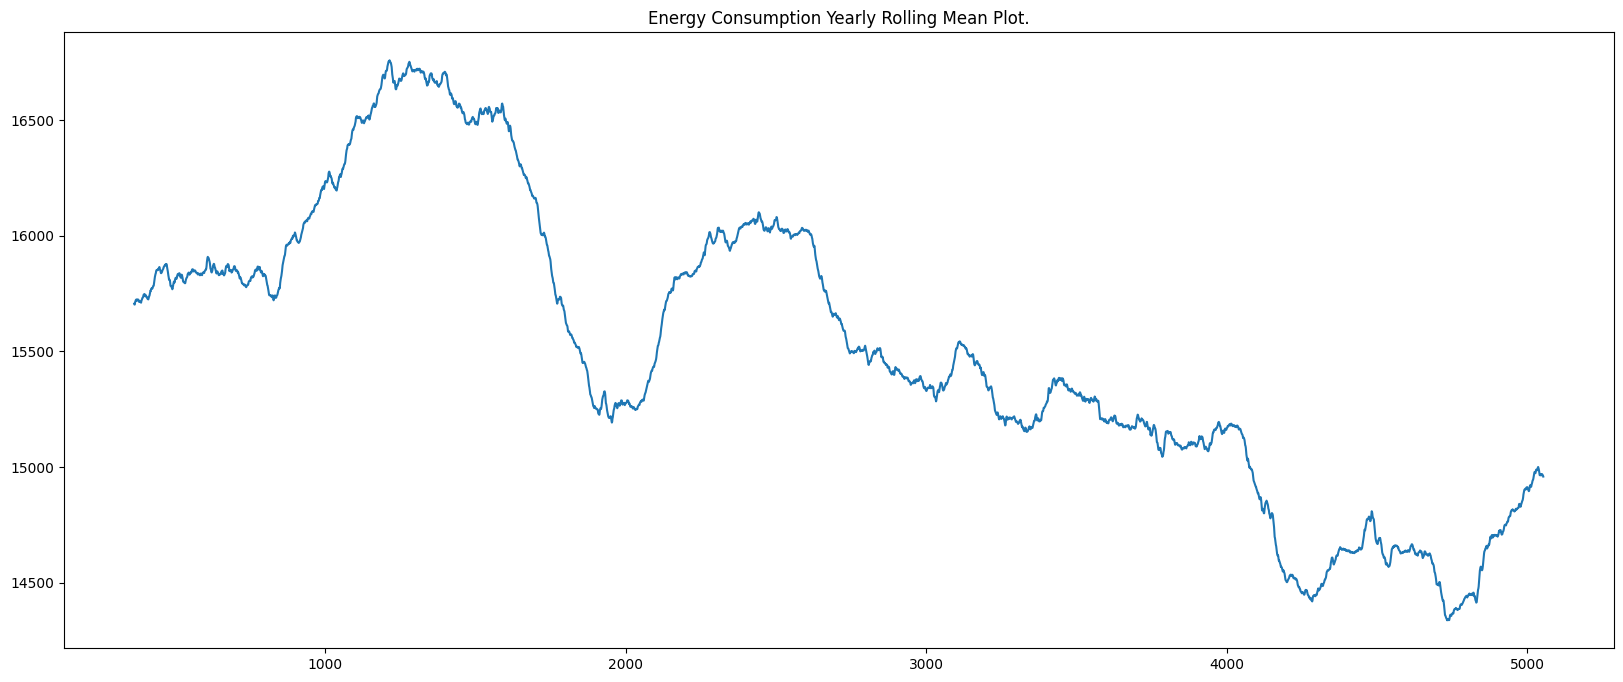

In [11]:
STANDARD_SIZE = (20, 8)
plt.figure(figsize = STANDARD_SIZE)
plt.title('Energy Consumption Yearly Rolling Mean Plot.')
aep_df['AEP_MW'].rolling(window = 365).mean().plot();

**Observation**

The *ADF* test suggests that the data `is stationary`. However, **the rolling mean plot suggests otherwise**.   

**Next**, I will be apply first order differencing and see the impact it has on the data in making it truly `stationary`.

**Subsequently**, I will experiment with ARIMA and Prophet, before eventually stacking models (calibration) for improved results where possible.

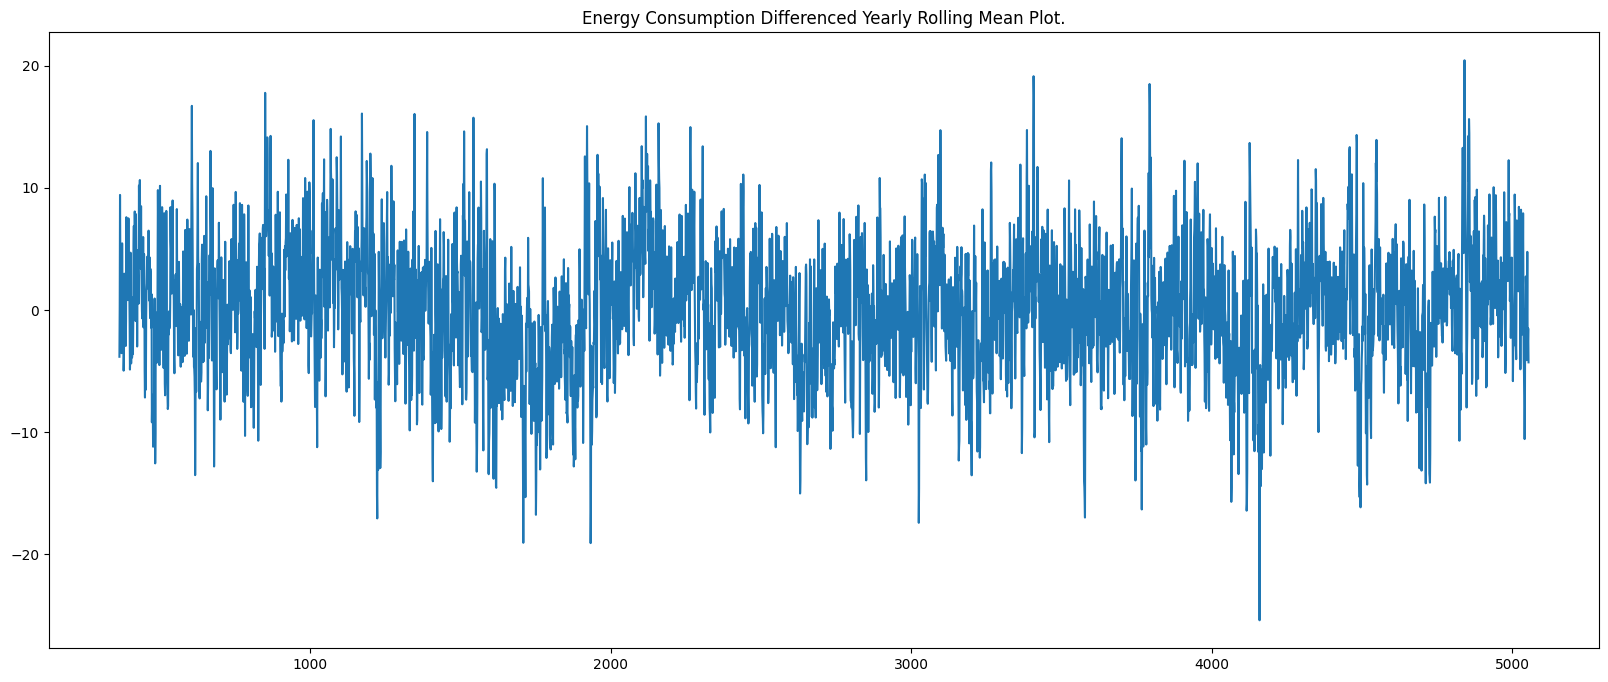

In [12]:
aep_df['AEP_MW_diff'] = aep_df['AEP_MW'].diff()

plt.figure(figsize = STANDARD_SIZE)
plt.title('Energy Consumption Differenced Yearly Rolling Mean Plot.')
aep_df['AEP_MW_diff'].rolling(window = 365).mean().plot();

**Observation**

The differenced version is much more stable, with a mean around 0, and a roughly similar spread... When training my actual arima models, I'll likely be working with `d = 1`. I will run hyper-parameter finetuning though.

## Other Visualisations

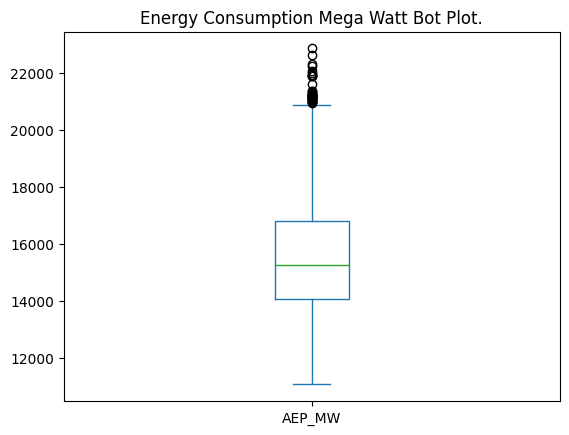

In [13]:
plt.title('Energy Consumption Mega Watt Bot Plot.')
aep_df['AEP_MW'].plot.box();

**Observation**

Some extreme usage values are observed... However, I will check if they occur randomly or in certain months/meaningful dates in order to determinf if they are truly outliers of reasonable.

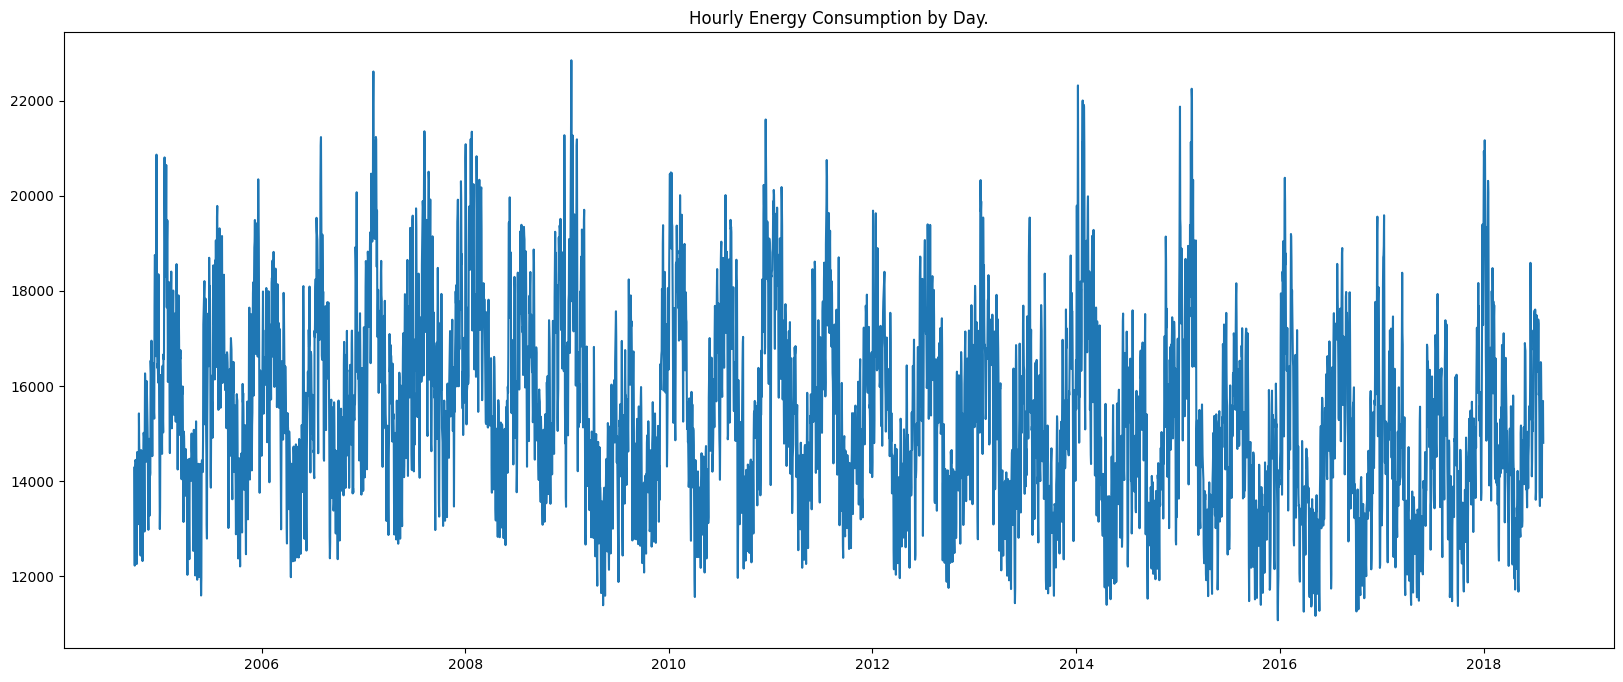

In [14]:
plt.figure(figsize = STANDARD_SIZE)
plt.plot(sorted(aep_df['ds']), (aep_df['AEP_MW']))
plt.title('Hourly Energy Consumption by Day.');

**Observation**

Some notable seasonality.... Next, I will visualise what the consumption levels look like **per season** of the year.

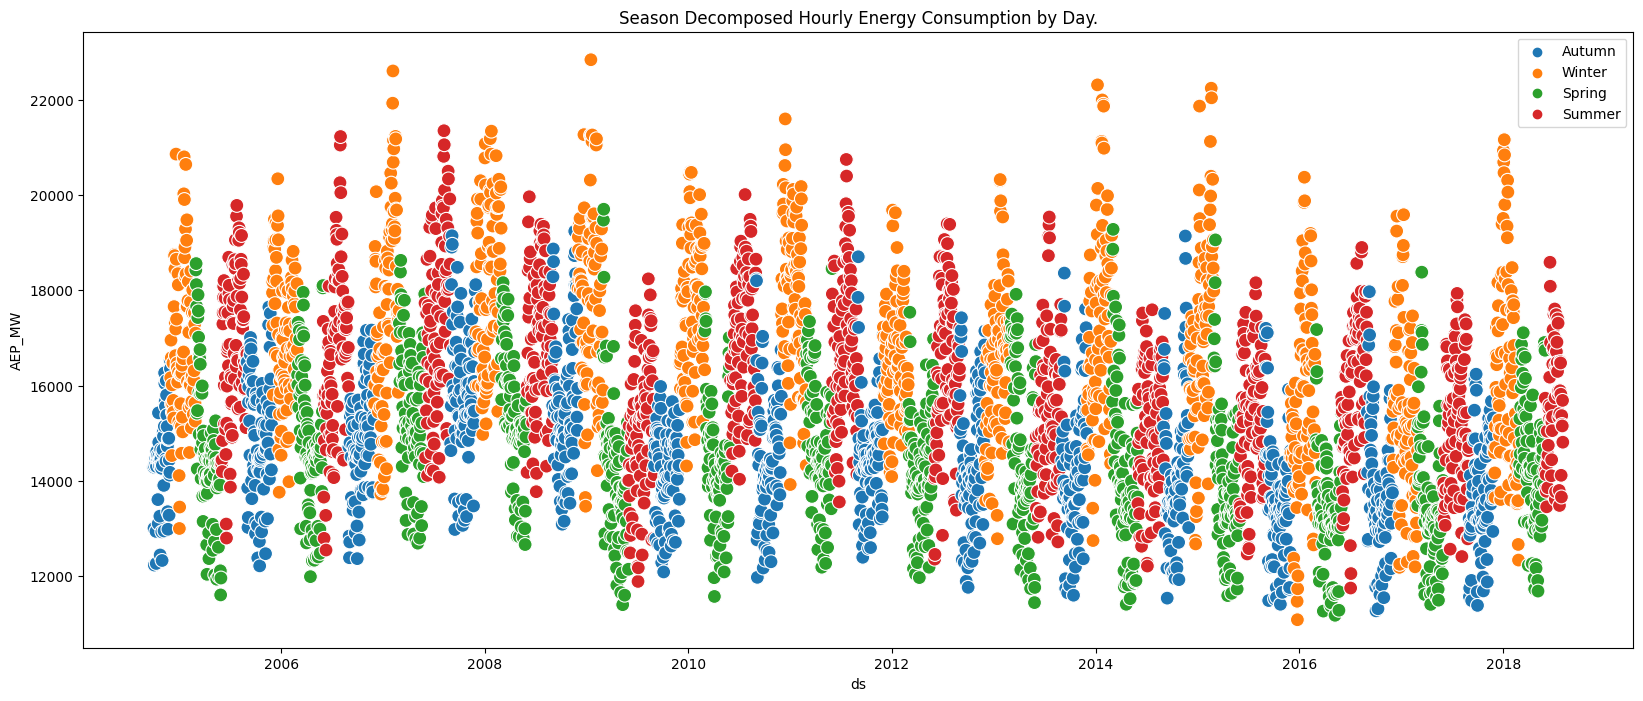

In [15]:
plt.figure(figsize = STANDARD_SIZE)

aep_df_sorted = aep_df.sort_values('ds')
sns.scatterplot(
    data = aep_df_sorted, x = 'ds', y = 'AEP_MW',
    hue = 'season', palette = 'tab10', s = 100)

plt.title('Season Decomposed Hourly Energy Consumption by Day.')
plt.legend()
plt.show()

**Observation**   

Consumption levels over the years are consistently highest during `Winter`, and `Summer` months, in that order.... While `Autumn`, and `Spring` are more on the moderate side.   

Plus, it kind of looks like there is a subtle downward trend as time goes on, but I can't say for sure... I'll let prophet reveal more information subsequently.

# Time Series Modelling

**Note** that I will train on all years, `except the last 2`. I will then test on the last year, and if the need be, I will calibrate with the second to the last year, then predict again on the last year.   

I will do the above mentioned for both Prophet and ARIMA.

## Data Splits

In [16]:
aep_df.rename(columns = {'AEP_MW' : 'y'}, inplace = True)

train = aep_df[aep_df['year'] <= aep_df['year'].max() - 2]

calib = aep_df[
    (aep_df['year'] > train['year'].max()) &
    (aep_df['year'] <= aep_df['year'].max() - 1)]

test = aep_df[aep_df['year'] == aep_df['year'].max()]


print(f'There are {len(train)} train samples. The first year is {train["year"].min()}, and the last is {train["year"].max()}')
print(f'There are {len(calib)} calibration samples. The first year is {calib["year"].min()}, and the last is {calib["year"].max()}')
print(f'There are {len(test)} test samples. The first year is {test["year"].min()}, and the last is {test["year"].max()}')

There are 4475 train samples. The first year is 2004, and the last is 2016
There are 365 calibration samples. The first year is 2017, and the last is 2017
There are 215 test samples. The first year is 2018, and the last is 2018


## Base Prophet Training

In [17]:
base_prophet_model = Prophet()

# base_prophet_model.fit(train.iloc[:, :2])
# future = base_prophet_model.make_future_dataframe(periods = 30)
# forecast = base_prophet_model.predict(future)

In [18]:
# forecast.shape

In [19]:
# forecast.head()

In [20]:
# forecast.trend.plot();

## ARIMA Prophet Training

In [21]:
# auto_model = auto_arima(aep_df['AEP_MW'], seasonal = True, trace = True)